In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from pytorch_msssim import ssim
import torch.nn.functional as F
import os
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, real_dir, synthetic_dir, transform=None, mode='train', split=0.9):
        self.real_dir = real_dir
        self.synthetic_dir = synthetic_dir
        self.transform = transform
        self.mode = mode

        # Load and split data
        self.synthetic_images = sorted(os.listdir(synthetic_dir))
        np.random.shuffle(self.synthetic_images)  # Shuffle the dataset
        split_index = int(len(self.synthetic_images) * split)
        
        if mode == 'train':
            self.synthetic_images = self.synthetic_images[:split_index]
        elif mode == 'val':
            self.synthetic_images = self.synthetic_images[split_index:]

    def __len__(self):
        return len(self.synthetic_images)

    def __getitem__(self, idx):
        synthetic_img_name = self.synthetic_images[idx]
        synthetic_img = Image.open(os.path.join(self.synthetic_dir, synthetic_img_name)).convert('L')
        real_img_name = synthetic_img_name.split('_synthetic')[0] + '.jpg'
        real_img = Image.open(os.path.join(self.real_dir, real_img_name)).convert('L')

        if self.transform:
            synthetic_img = self.transform(synthetic_img)
            real_img = self.transform(real_img)

        return synthetic_img, real_img

# Set transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create datasets and dataloaders
train_dataset = CustomDataset('medieval_sinhala', 'synthetic_medieval_sinhala4', transform=transform, mode='train')
val_dataset = CustomDataset('medieval_sinhala', 'synthetic_medieval_sinhala4', transform=transform, mode='val')

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [3]:
# Generator (U-Net)
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        self.down1 = self.conv_block(1, 64, False)
        self.down2 = self.conv_block(64, 128)
        self.down3 = self.conv_block(128, 256)
        self.down4 = self.conv_block(256, 512)
        self.down5 = self.conv_block(512, 512)
        self.up1 = self.upconv_block(512, 512)
        self.up2 = self.upconv_block(1024, 256)
        self.up3 = self.upconv_block(512, 128)
        self.up4 = self.upconv_block(256, 64)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def conv_block(self, in_channels, out_channels, batch_norm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)

    def upconv_block(self, in_channels, out_channels):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        u1 = self.up1(d5)
        u2 = self.up2(torch.cat([u1, d4], 1))
        u3 = self.up3(torch.cat([u2, d3], 1))
        u4 = self.up4(torch.cat([u3, d2], 1))
        return self.final(torch.cat([u4, d1], 1))

# Discriminator (PatchGAN)
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super(PatchDiscriminator, self).__init__()
        self.model = nn.Sequential(
            self.conv_block(2, 64, False),
            self.conv_block(64, 128),
            self.conv_block(128, 256),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def conv_block(self, in_channels, out_channels, batch_norm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Epoch [1/100], D Loss: 0.3697, G Loss: 13.9952
Epoch [1/100], Train G Loss: 16.9986, Train D Loss: 0.5248, Val G Loss: 19.7973
Epoch [2/100], D Loss: 0.5312, G Loss: 12.3393
Epoch [2/100], Train G Loss: 11.2329, Train D Loss: 0.5667, Val G Loss: 9.3999
Epoch [3/100], D Loss: 0.5146, G Loss: 10.1311
Epoch [3/100], Train G Loss: 9.5265, Train D Loss: 0.5881, Val G Loss: 7.8753
Epoch [4/100], D Loss: 0.6918, G Loss: 8.1066
Epoch [4/100], Train G Loss: 8.8272, Train D Loss: 0.5461, Val G Loss: 6.7302
Epoch [5/100], D Loss: 0.3755, G Loss: 9.6042
Epoch [5/100], Train G Loss: 9.0108, Train D Loss: 0.4781, Val G Loss: 6.7428
Epoch [6/100], D Loss: 0.3831, G Loss: 9.1616
Epoch [6/100], Train G Loss: 8.8877, Train D Loss: 0.4392, Val G Loss: 6.5876
Epoch [7/100], D Loss: 0.1901, G Loss: 8.1156
Epoch [7/100], Train G Loss: 9.2762, Train D Loss: 0.3679, Val G Loss: 6.3896
Epoch [8/100], D Loss: 0.1918, G Loss: 10.1310
Epoch [8/100], Train G Loss: 9.3882, Train D Loss: 0.3370, Val G Loss: 6.0426
E

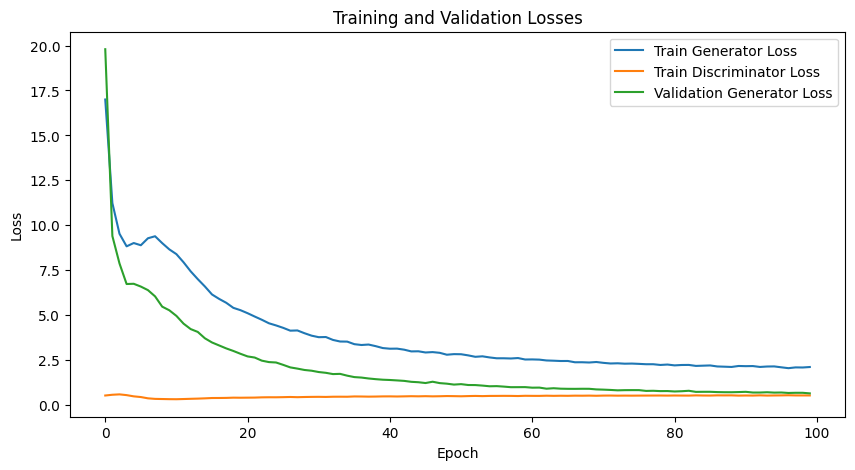

In [14]:
# Initialize the models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = UNetGenerator().to(device)
discriminator = PatchDiscriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss functions and weights
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()
lambda_L1 = 100

# Store losses for plotting
train_losses_G = []
train_losses_D = []
val_losses_G = []

# Training loop for Pix2Pix
n_epochs = 100
for epoch in range(n_epochs):
    generator.train()
    discriminator.train()
    
    total_loss_G = 0.0
    total_loss_D = 0.0
    
    for i, (synthetic_img, real_img) in enumerate(train_dataloader):
        real_img = real_img.to(device)
        synthetic_img = synthetic_img.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        
        # Forward pass through the discriminator to get the output shape
        real_output = discriminator(torch.cat((synthetic_img, real_img), 1))

        # Dynamically create labels that match the discriminator output size
        real_label = torch.ones_like(real_output).to(device)
        fake_label = torch.zeros_like(real_output).to(device)

        real_pair = torch.cat((synthetic_img, real_img), 1)
        fake_img = generator(synthetic_img)
        fake_pair = torch.cat((synthetic_img, fake_img), 1)

        real_output = discriminator(real_pair)
        fake_output = discriminator(fake_pair.detach())

        loss_D_real = criterion_GAN(real_output, real_label)
        loss_D_fake = criterion_GAN(fake_output, fake_label)
        loss_D = (loss_D_real + loss_D_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_pair)
        loss_G_GAN = criterion_GAN(fake_output, real_label)
        loss_G_L1 = criterion_L1(fake_img, real_img) * lambda_L1
        loss_G = loss_G_GAN + loss_G_L1

        loss_G.backward()
        optimizer_G.step()

        # Accumulate losses for the current epoch
        total_loss_G += loss_G.item()
        total_loss_D += loss_D.item()

        
    print(f"Epoch [{epoch+1}/{n_epochs}], " f"D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")

    # Average losses over the epoch
    avg_loss_G = total_loss_G / len(train_dataloader)
    avg_loss_D = total_loss_D / len(train_dataloader)
    train_losses_G.append(avg_loss_G)
    train_losses_D.append(avg_loss_D)

    # Validation Step+
    generator.eval()
    val_loss_G = 0.0

    with torch.no_grad():
        for synthetic_img, real_img in val_dataloader:
            synthetic_img = synthetic_img.to(device)
            real_img = real_img.to(device)

            fake_img = generator(synthetic_img)
            loss_G_L1 = criterion_L1(fake_img, real_img) * lambda_L1
            val_loss_G += loss_G_L1.item()

    # Average validation generator loss
    avg_val_loss_G = val_loss_G / len(val_dataloader)
    val_losses_G.append(avg_val_loss_G)

    print(f"Epoch [{epoch+1}/{n_epochs}], Train G Loss: {avg_loss_G:.4f}, "
          f"Train D Loss: {avg_loss_D:.4f}, Val G Loss: {avg_val_loss_G:.4f}")

    # Save generated images for monitoring
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            fake_images = generator(synthetic_img)
            save_image(fake_images, f'final_output/fake_images_epoch_{epoch + 1}.png', nrow=4, normalize=True)

    # Save model checkpoints
    if (epoch + 1) % 20 == 0:
        torch.save(generator.state_dict(), f'final_model/generator_epoch_{epoch + 1}.pth')
        torch.save(discriminator.state_dict(), f'final_model/discriminator_epoch_{epoch + 1}.pth')

print("Training completed!")

# ----------------------
# Plot the Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses_G, label='Train Generator Loss')
plt.plot(train_losses_D, label='Train Discriminator Loss')
plt.plot(val_losses_G, label='Validation Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [26]:
# Save losses to a CSV file
def save_losses_to_csv(train_generator_losses, train_discriminator_losses, val_generator_losses, filename='Pix2Pix_losses.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train Generator Loss', 'Train Discriminator Loss', 'Val Generator Loss'])
        for i, (train_g_loss, train_d_loss, val_g_loss) in enumerate(zip(train_generator_losses, train_discriminator_losses, val_generator_losses)):
            writer.writerow([i+1, train_g_loss, train_d_loss, val_g_loss])

# After training loop, save the losses
save_losses_to_csv(train_losses_G, train_losses_D, val_losses_G, filename='Reconstruction_losses.csv')

In [ ]:
# Load losses from CSV file
def load_losses_from_csv(filename='Reconstruction_losses.csv'):
    train_generator_losses = []
    train_discriminator_losses = []
    val_generator_losses = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        for row in reader:
            epoch, train_g_loss, train_d_loss, val_g_loss = row
            train_generator_losses.append(float(train_g_loss))
            train_discriminator_losses.append(float(train_d_loss))
            val_generator_losses.append(float(val_g_loss))

    return train_generator_losses, train_discriminator_losses, val_generator_losses

# Load the losses from CSV
train_loss_g, train_loss_d, val_loss_g = load_losses_from_csv('Reconstruction_losses.csv')

# Plot loaded losses
epochs_range = range(1, len(train_loss_g) + 1)

plt.figure(figsize=(10, 6))

# Plot generator and discriminator losses
plt.plot(epochs_range, train_loss_g, label='Train Generator Loss', color='blue')
plt.plot(epochs_range, train_loss_d, label='Train Discriminator Loss', color='green')
plt.plot(epochs_range, val_loss_g, label='Validation Generator Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'final_model/generator_epoch_100.pth'
model = UNetGenerator().to(device)
model.load_state_dict(torch.load(model_path))

model.eval()

# Load an image (for example, from the synthetic dataset)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
image_path = 'mdvs1 _synthetic_image_14.jpg'
image = Image.open(image_path).convert('L')
image = transform(image).unsqueeze(0).to(device)

# Reconstruct the image
with torch.no_grad():
    reconstructed_img = model(image)

reconstructed_img = reconstructed_img.cpu().squeeze(0)
save_image(reconstructed_img, 'reconstructed719_image.jpg')


C:\Users\Admin\AppData\Local\Temp\ipykernel_8272\3279193526.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


C:\Users\Admin\AppData\Local\Temp\ipykernel_18584\2470389596.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('final_model/generator

Filename: ('test_synthetic_medieval_sinhala4\\mdvs40 _synthetic_image_0.jpg',) - MSE: 0.0004, SSIM: 0.9968
Filename: ('test_synthetic_medieval_sinhala4\\mdvs612 _synthetic_image_10.jpg',) - MSE: 0.0005, SSIM: 0.9959
Filename: ('test_synthetic_medieval_sinhala4\\mdvs133 _synthetic_image_8.jpg',) - MSE: 0.0006, SSIM: 0.9857
Filename: ('test_synthetic_medieval_sinhala4\\mdvs138 _synthetic_image_17.jpg',) - MSE: 0.0008, SSIM: 0.9933
Filename: ('test_synthetic_medieval_sinhala4\\mdvs167 _synthetic_image_4.jpg',) - MSE: 0.0001, SSIM: 0.9991
Filename: ('test_synthetic_medieval_sinhala4\\mdvs28 _synthetic_image_9.jpg',) - MSE: 0.0003, SSIM: 0.9975
Filename: ('test_synthetic_medieval_sinhala4\\mdvs682_synthetic_image_18.jpg',) - MSE: 0.0003, SSIM: 0.9979
Filename: ('test_synthetic_medieval_sinhala4\\mdvs675 _synthetic_image_9.jpg',) - MSE: 0.0003, SSIM: 0.9976
Filename: ('test_synthetic_medieval_sinhala4\\mdvs372 _synthetic_image_13.jpg',) - MSE: 0.0006, SSIM: 0.9948
Filename: ('test_synthetic_

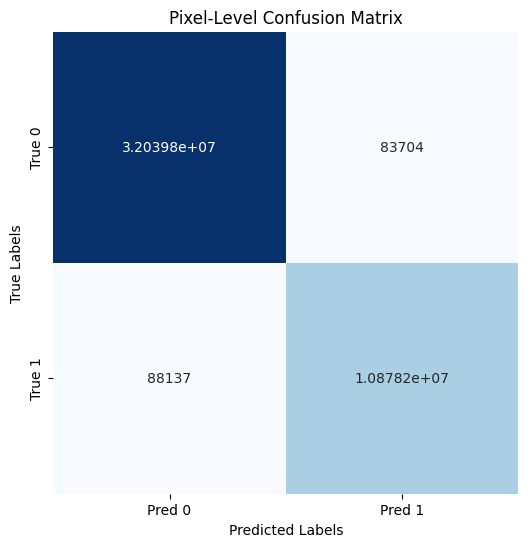

In [16]:
# Testing Code (A thorough evaluation of the model on the test set)
# Metrics include MSE, SSIM, IoU, Dice Coefficient, Confusion Matrix, and Classification Report

class PairedDataset(Dataset):
    def __init__(self, synthetic_dir, original_dir, transform=None):
        self.synthetic_dir = synthetic_dir
        self.original_dir = original_dir
        self.transform = transform
        self.synthetic_images = [f for f in os.listdir(synthetic_dir) if os.path.isfile(os.path.join(synthetic_dir, f))]
        self.base_names = [f.split('_synthetic_image')[0] for f in self.synthetic_images]

    def __len__(self):
        return len(self.synthetic_images)

    def __getitem__(self, idx):
        synth_img_name = os.path.join(self.synthetic_dir, self.synthetic_images[idx])
        synth_image = Image.open(synth_img_name).convert('L')
        base_name = self.base_names[idx]
        orig_img_name = os.path.join(self.original_dir, base_name + '.jpg')
        orig_image = Image.open(orig_img_name).convert('L')
        
        if self.transform:
            synth_image = self.transform(synth_image)
            orig_image = self.transform(orig_image)

        return synth_image, orig_image, synth_img_name 


# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset and DataLoader
synthetic_dir = 'test_synthetic_medieval_sinhala4'
original_dir = 'medieval_sinhala'
dataset = PairedDataset(synthetic_dir, original_dir, transform)
loader = DataLoader(dataset, batch_size=1, shuffle=True)


# Load the trained generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = UNetGenerator().to(device)
generator.load_state_dict(torch.load('final_model/generator_epoch_100.pth'))
generator.eval()

# Define loss functions
mse_criterion = nn.MSELoss()
ssim_values = []
mse_values = []

# Lists to store true and predicted pixel values
all_true_labels = []
all_predicted_labels = []

# Evaluation Loop
with torch.no_grad():
    for synth_img, orig_img, filename in loader:
        synth_img, orig_img = synth_img.to(device), orig_img.to(device)
        reconstructed_img = generator(synth_img)

        # Compute MSE and SSIM
        mse = mse_criterion(reconstructed_img, orig_img)
        mse_values.append(mse.item())
        ssim_value = ssim(reconstructed_img, orig_img, data_range=2, size_average=True)
        ssim_values.append(ssim_value.item())

        # Convert images to binary masks (0 for black, 1 for white)
        real_img_binary = (orig_img > 0).int()  # Convert to binary mask (0 for black, 1 for white)
        reconstructed_img_binary = (reconstructed_img > 0).int()

        # Flatten images to 1D arrays and store for later confusion matrix calculation
        all_true_labels.extend(real_img_binary.view(-1).cpu().numpy())
        all_predicted_labels.extend(reconstructed_img_binary.view(-1).cpu().numpy())

        # Print details for each image
        print(f"Filename: {filename} - MSE: {mse.item():.4f}, SSIM: {ssim_value.item():.4f}")

# Compute average MSE and SSIM over the entire test set
average_mse = np.mean(mse_values)
average_ssim = np.mean(ssim_values)

# Convert lists to tensors for calculations
all_true_labels_tensor = torch.tensor(all_true_labels)
all_predicted_labels_tensor = torch.tensor(all_predicted_labels)

# Calculate intersection and union for IoU and Dice Coefficient
intersection = torch.sum((all_true_labels_tensor == 1) & (all_predicted_labels_tensor == 1)).item()
union = torch.sum((all_true_labels_tensor == 1) | (all_predicted_labels_tensor == 1)).item()

# Calculate Dice Coefficient
dice_coefficient = (2 * intersection) / (
    2 * intersection + torch.sum(all_true_labels_tensor == 1).item() +
    torch.sum(all_predicted_labels_tensor == 1).item() - 2 * intersection
)

# Calculate IoU
iou = intersection / union if union > 0 else 0

# Display Evaluation Metrics
print("\n")
print('----------------------------------------')
print("Evaluation Metrics:")
print('----------------------------------------')
print(f"Average MSE: {average_mse:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Dice Coefficient: {dice_coefficient:.4f}")
print(f"IoU: {iou:.4f}")

# Compute the confusion matrix using scikit-learn
cm = confusion_matrix(all_true_labels, all_predicted_labels)
print("\nConfusion Matrix:")
print(cm)

# Generate and print the classification report
report = classification_report(all_true_labels, all_predicted_labels, target_names=['Background (0)', 'Ink (1)'])
print("\nClassification Report:")
print(report)

# Plot the confusion matrix without percentages
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Pred 0', 'Pred 1'], 
            yticklabels=['True 0', 'True 1'],
            cbar=False, ax=ax, annot_kws={"size": 10})

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Pixel-Level Confusion Matrix')
plt.show()



In [21]:
# Create output directory for reconstructed images
output_dir = 'reconstructed_images'
os.makedirs(output_dir, exist_ok=True)

# Dataset and DataLoader
synthetic_dir = 'test_synthetic_medieval_sinhala4'
original_dir = 'medieval_sinhala'
dataset = PairedDataset(synthetic_dir, original_dir, transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False) 

# Load the pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetGenerator().to(device)
model.load_state_dict(torch.load('final_model/generator_epoch_100.pth'))
model.eval()

# Setup loss criterion and metrics
mse_criterion = nn.MSELoss()
ssim_values = []
mse_values = []

with torch.no_grad():
    for idx, (synth_img, orig_img, filename) in enumerate(loader):
        synth_img, orig_img = synth_img.to(device), orig_img.to(device)
        reconstructed_img = model(synth_img)

        # Compute MSE and SSIM
        mse = mse_criterion(reconstructed_img, orig_img)
        mse_values.append(mse.item())
        ssim_value = ssim(reconstructed_img, orig_img, data_range=2, size_average=True)
        ssim_values.append(ssim_value.item())

        # Extract the base name from the filename and create the new name
        base_name = os.path.basename(filename[0]).replace('_synthetic_image', '_reconstructed')
        reconstructed_img_filename = os.path.join(output_dir, f'{base_name}')

        # Save the reconstructed image
        save_image(reconstructed_img, reconstructed_img_filename)

        # Print details for each image
        print(f"Filename: {filename} - MSE: {mse.item():.4f}, SSIM: {ssim_value.item():.4f}")
        print(f"Reconstructed image saved to: {reconstructed_img_filename}")

# Calculate and print average metrics
average_mse = np.mean(mse_values)
average_ssim = np.mean(ssim_values)
print(f"Average MSE: {average_mse:.4f}")
print(f"Average SSIM: {average_ssim:.4f}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_8272\2733202499.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('final_model/generator_epoc

Filename: ('test_synthetic_medieval_sinhala4\\mdvs1 _synthetic_image_0.jpg',) - MSE: 0.0003, SSIM: 0.9954
Reconstructed image saved to: reconstructed_images\mdvs1 _reconstructed_0.jpg
Filename: ('test_synthetic_medieval_sinhala4\\mdvs1 _synthetic_image_1.jpg',) - MSE: 0.0003, SSIM: 0.9954
Reconstructed image saved to: reconstructed_images\mdvs1 _reconstructed_1.jpg
Filename: ('test_synthetic_medieval_sinhala4\\mdvs1 _synthetic_image_10.jpg',) - MSE: 0.0003, SSIM: 0.9958
Reconstructed image saved to: reconstructed_images\mdvs1 _reconstructed_10.jpg
Filename: ('test_synthetic_medieval_sinhala4\\mdvs1 _synthetic_image_11.jpg',) - MSE: 0.0004, SSIM: 0.9943
Reconstructed image saved to: reconstructed_images\mdvs1 _reconstructed_11.jpg
Filename: ('test_synthetic_medieval_sinhala4\\mdvs1 _synthetic_image_12.jpg',) - MSE: 0.0004, SSIM: 0.9946
Reconstructed image saved to: reconstructed_images\mdvs1 _reconstructed_12.jpg
Filename: ('test_synthetic_medieval_sinhala4\\mdvs1 _synthetic_image_13.jp